# The Battle of Neighborhood 3.3
## Foursquare Venue Nearby and Clustering 

In [1]:
# intalling folium
!pip install folium

In [17]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

# Nominatim converts an address into latitude and langitude values
from geopy.geocoders import Nominatim

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

import folium
import requests
import json
from bs4 import BeautifulSoup

from pandas.io.json import json_normalize
print("all libraries have been imported");

all libraries have been imported


## Part 3: Finding Nearby Venues

In [4]:
# The code was removed by Watson Studio for sharing.

,School Name,Latitude,Longitude
0,ADMIRALTY SECONDARY SCHOOL,1.445960,103.802785
1,AHMAD IBRAHIM SECONDARY SCHOOL,1.436070,103.830150
2,ANDERSON SECONDARY SCHOOL,1.375088,103.851594
3,ANDERSON SERANGOON JUNIOR COLLEGE,1.378750,103.845911
4,ANG MO KIO SECONDARY SCHOOL,1.367770,103.842520


In [5]:
latitude_na = schcor_df[schcor_df['Latitude'] >= 2].index
schcor_df.drop(latitude_na, inplace=True)
schcor_df.shape

(162, 3)

In [6]:
CLIENT_ID = 'YRKZ44SHQRO4UDMIPWFL2WICIH5BY0KLFEEBPUWKKYD2NUUK'
CLIENT_SECRET = 'OJCVO344VVYQTUOLCTCUYQ12D2XUHI0TYFIOFBYSKSNRV5F0'
VERSION = '20180605'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: YRKZ44SHQRO4UDMIPWFL2WICIH5BY0KLFEEBPUWKKYD2NUUK
CLIENT_SECRET:OJCVO344VVYQTUOLCTCUYQ12D2XUHI0TYFIOFBYSKSNRV5F0


In [7]:
sch_latitude = schcor_df.loc[0, 'Latitude']
sch_longitude = schcor_df.loc[0, 'Longitude']

sch_name = schcor_df.loc[0, 'School Name']

print('Latitude and longitude values of {} are {}, {}.'.format(sch_name,sch_latitude,sch_longitude))

Latitude and longitude values of ADMIRALTY SECONDARY SCHOOL are 1.44596016849914, 103.8027848.


In [8]:
# set the number of venues of returned by Foursquare API to be 100
LIMIT = 100 

# define radius as 1000 meters
radius = 500

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    sch_latitude,
    sch_longitude,
    radius,
    LIMIT)

# display URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=YRKZ44SHQRO4UDMIPWFL2WICIH5BY0KLFEEBPUWKKYD2NUUK&client_secret=OJCVO344VVYQTUOLCTCUYQ12D2XUHI0TYFIOFBYSKSNRV5F0&v=20180605&ll=1.44596016849914,103.8027848&radius=500&limit=100'

In [9]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed2913083525f001b4480b8'},
 'response': {'headerLocation': 'Woodlands',
  'headerFullLocation': 'Woodlands, Singapore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 1.4504601729991446,
    'lng': 103.80727783319446},
   'sw': {'lat': 1.4414601639991356, 'lng': 103.79829176680553}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c65fedbf101ef3bb4d56be9',
       'name': 'Woodlands Crescent Park',
       'location': {'address': 'Woodlands Crescent',
        'lat': 1.4451583508356642,
        'lng': 103.80298459009906,
        'labeledLatLngs': [{'label': 'display',
          'lat': 1.4451583508356642,
          'lng': 103.80298459009906}],
        'distance': 91,
        'cc':

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Woodlands Crescent Park,Park,1.445158,103.802985
1,Woodlands Mart,Shopping Plaza,1.445868,103.798627
2,Buzz @ Woodlands Mart,Paper / Office Supplies Store,1.443994,103.799860
3,Fork & Spoon,Food Court,1.445120,103.798602


In [12]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['School Name', 
                  'School Latitude', 
                  'School Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
singapore_venues = getNearbyVenues(names=schcor_df['School Name'],
                                   latitudes=schcor_df['Latitude'],
                                   longitudes=schcor_df['Longitude']
                                  )

ADMIRALTY SECONDARY SCHOOL
AHMAD IBRAHIM SECONDARY SCHOOL
ANDERSON SECONDARY SCHOOL
ANDERSON SERANGOON JUNIOR COLLEGE
ANG MO KIO SECONDARY SCHOOL
ANGLICAN HIGH SCHOOL
ANGLO-CHINESE JUNIOR COLLEGE
ANGLO-CHINESE SCHOOL (BARKER ROAD)
ANGLO-CHINESE SCHOOL (INDEPENDENT)
ASSUMPTION ENGLISH SCHOOL
ASSUMPTION PATHWAY SCHOOL
BARTLEY SECONDARY SCHOOL
BEATTY SECONDARY SCHOOL
BEDOK GREEN SECONDARY SCHOOL
BEDOK SOUTH SECONDARY SCHOOL
BEDOK VIEW SECONDARY SCHOOL
BENDEMEER SECONDARY SCHOOL
BOON LAY SECONDARY SCHOOL
BOWEN SECONDARY SCHOOL
BROADRICK SECONDARY SCHOOL
BUKIT BATOK SECONDARY SCHOOL
BUKIT MERAH SECONDARY SCHOOL
BUKIT PANJANG GOVT. HIGH SCHOOL
BUKIT VIEW SECONDARY SCHOOL
CANBERRA SECONDARY SCHOOL
CATHOLIC HIGH SCHOOL
CATHOLIC JUNIOR COLLEGE
CEDAR GIRLS' SECONDARY SCHOOL
CHANGKAT CHANGI SECONDARY SCHOOL
CHIJ KATONG CONVENT
CHIJ SECONDARY (TOA PAYOH)
CHIJ ST. JOSEPH'S CONVENT
CHIJ ST. NICHOLAS GIRLS' SCHOOL
CHIJ ST. THERESA'S CONVENT
CHRIST CHURCH SECONDARY SCHOOL
CHUA CHU KANG SECONDARY SCHOO

In [19]:
print(singapore_venues.shape)
singapore_venues.head()

(2535, 7)


,School Name,School Latitude,School Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ADMIRALTY SECONDARY SCHOOL,1.44596,103.802785,Woodlands Crescent Park,1.445158,103.802985,Park
1,ADMIRALTY SECONDARY SCHOOL,1.44596,103.802785,Woodlands Mart,1.445868,103.798627,Shopping Plaza
2,ADMIRALTY SECONDARY SCHOOL,1.44596,103.802785,Buzz @ Woodlands Mart,1.443994,103.799860,Paper / Office Supplies Store
3,ADMIRALTY SECONDARY SCHOOL,1.44596,103.802785,Fork & Spoon,1.445120,103.798602,Food Court
4,AHMAD IBRAHIM SECONDARY SCHOOL,1.43607,103.830150,Blk 171 Yishun Ave 7,1.436794,103.831819,Coffee Shop


In [20]:
singapore_venues['Venue Category'].value_counts()

Coffee Shop                                 211
Food Court                                  187
Chinese Restaurant                          130
Asian Restaurant                             98
Bus Station                                  96
Fast Food Restaurant                         96
Café                                         71
Noodle House                                 69
Supermarket                                  61
Convenience Store                            57
Park                                         52
Bakery                                       48
Seafood Restaurant                           48
Indian Restaurant                            44
Japanese Restaurant                          40
Dessert Shop                                 40
Shopping Mall                                38
Bus Stop                                     38
Thai Restaurant                              35
Grocery Store                                34
Vegetarian / Vegan Restaurant           

In [21]:
singapore_venues.groupby('School Name').count()

,School Latitude,School Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
School Name,,,,,,
ADMIRALTY SECONDARY SCHOOL,4,4,4,4,4,4
AHMAD IBRAHIM SECONDARY SCHOOL,8,8,8,8,8,8
ANDERSON SECONDARY SCHOOL,14,14,14,14,14,14
ANDERSON SERANGOON JUNIOR COLLEGE,10,10,10,10,10,10
ANG MO KIO SECONDARY SCHOOL,12,12,12,12,12,12
ANGLICAN HIGH SCHOOL,15,15,15,15,15,15
ANGLO-CHINESE JUNIOR COLLEGE,36,36,36,36,36,36
ANGLO-CHINESE SCHOOL (BARKER ROAD),7,7,7,7,7,7
ANGLO-CHINESE SCHOOL (INDEPENDENT),5,5,5,5,5,5


In [22]:
print('There are {} unique categories.'.format(len(singapore_venues['Venue Category'].unique())))

There are 233 unique categories.


In [23]:
# one hot encoding
singapore_onehot = pd.get_dummies(singapore_venues[['Venue Category']], prefix="", prefix_sep="")

# add school name column back to dataframe
singapore_onehot['School Name'] = singapore_venues['School Name'] 

# move school name column to the first column
col_name="School Name"
first_col = singapore_onehot.pop(col_name)
singapore_onehot.insert(0, col_name, first_col)

singapore_onehot.head()

,School Name,Airport,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bakery,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Bookstore,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Casino,Chinese Aristocrat Restaurant,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Auditorium,College Bookstore,College Cafeteria,College Theater,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,High School,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,ADMIRALTY SECONDARY SCHOOL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ADMIRALTY SECONDARY SCHOOL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [24]:
singapore_onehot.shape

(2535, 234)

Analyze each Neighborhood

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
singapore_grouped = singapore_onehot.groupby('School Name').mean().reset_index()
singapore_grouped.head()

,School Name,Airport,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bakery,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Bookstore,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Casino,Chinese Aristocrat Restaurant,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Auditorium,College Bookstore,College Cafeteria,College Theater,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,High School,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,ADMIRALTY SECONDARY SCHOOL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [26]:
singapore_grouped.shape

(162, 234)

In [118]:
gym = singapore_grouped[['School Name','Gym', 'Gym / Fitness Center', 'Bookstore']]

gym ['Gym Center'] = gym['Gym']  + gym['Gym / Fitness Center']

gym.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,School Name,Gym,Gym / Fitness Center,Bookstore,Gym Center
0,ADMIRALTY SECONDARY SCHOOL,0.0,0.0,0.0,0.0
1,AHMAD IBRAHIM SECONDARY SCHOOL,0.0,0.0,0.0,0.0
2,ANDERSON SECONDARY SCHOOL,0.0,0.0,0.0,0.0
3,ANDERSON SERANGOON JUNIOR COLLEGE,0.0,0.0,0.0,0.0
4,ANG MO KIO SECONDARY SCHOOL,0.0,0.0,0.0,0.0


In [119]:
gymcenter = gym.sort_values(['Gym Center'])

gymcenter1 = gymcenter.tail(n=10)

gymcenter1

,School Name,Gym,Gym / Fitness Center,Bookstore,Gym Center
35,CHUA CHU KANG SECONDARY SCHOOL,0.142857,0.000000,0.0,0.142857
103,PEIRCE SECONDARY SCHOOL,0.142857,0.000000,0.0,0.142857
80,METHODIST GIRLS' SCHOOL (SECONDARY),0.076923,0.076923,0.0,0.153846
111,REGENT SECONDARY SCHOOL,0.052632,0.105263,0.0,0.157895
61,HILLGROVE SECONDARY SCHOOL,0.090909,0.090909,0.0,0.181818
73,KUO CHUAN PRESBYTERIAN SECONDARY SCHOOL,0.200000,0.000000,0.0,0.200000
47,EAST SPRING SECONDARY SCHOOL,0.111111,0.111111,0.0,0.222222
41,CRESCENT GIRLS' SCHOOL,0.250000,0.000000,0.0,0.250000
43,DAMAI SECONDARY SCHOOL,0.125000,0.125000,0.0,0.250000
105,PRESBYTERIAN HIGH SCHOOL,0.250000,0.000000,0.0,0.250000


In [120]:
bookstore = singapore_grouped.sort_values(['Bookstore'])

bookstore1 = bookstore.tail(n=10)

bookstore2 = bookstore1[['School Name','Bookstore', 'Gym', 'Gym / Fitness Center']]

bookstore2

,School Name,Bookstore,Gym,Gym / Fitness Center
97,OUTRAM SECONDARY SCHOOL,0.020000,0.000000,0.000000
154,YISHUN TOWN SECONDARY SCHOOL,0.023256,0.000000,0.000000
129,ST. JOSEPH'S INSTITUTION,0.024096,0.000000,0.024096
161,ZHONGHUA SECONDARY SCHOOL,0.026316,0.000000,0.000000
62,HOLY INNOCENTS' HIGH SCHOOL,0.027027,0.000000,0.000000
134,TAMPINES SECONDARY SCHOOL,0.028571,0.028571,0.028571
49,EUNOIA JUNIOR COLLEGE,0.040000,0.000000,0.000000
113,RIVERSIDE SECONDARY SCHOOL,0.041667,0.000000,0.000000
112,RIVER VALLEY HIGH SCHOOL,0.055556,0.000000,0.000000
30,CHIJ SECONDARY (TOA PAYOH),0.111111,0.111111,0.000000


In [27]:
num_top_venues = 10

for hood in singapore_grouped['School Name']:
    print("----"+hood+"----")
    temp = singapore_grouped[singapore_grouped['School Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ADMIRALTY SECONDARY SCHOOL----
                           venue  freq
0                     Food Court  0.25
1                 Shopping Plaza  0.25
2                           Park  0.25
3  Paper / Office Supplies Store  0.25
4                        Airport  0.00
5                         Office  0.00
6                      Multiplex  0.00
7                         Museum  0.00
8                   Music School  0.00
9                    Music Store  0.00


----AHMAD IBRAHIM SECONDARY SCHOOL----
               venue  freq
0        Coffee Shop  0.25
1         Food Court  0.25
2         Hot Spring  0.12
3           Bus Stop  0.12
4   Asian Restaurant  0.12
5  Indian Restaurant  0.12
6         Playground  0.00
7       Optical Shop  0.00
8       Music School  0.00
9        Music Store  0.00


----ANDERSON SECONDARY SCHOOL----
                venue  freq
0          Food Court  0.36
1         Coffee Shop  0.07
2   Convenience Store  0.07
3   College Cafeteria  0.07
4        Noodle House 

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['School Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
school_venues_sorted = pd.DataFrame(columns=columns)
school_venues_sorted['School Name'] = singapore_grouped['School Name']

for ind in np.arange(singapore_grouped.shape[0]):
    school_venues_sorted.iloc[ind, 1:] = return_most_common_venues(singapore_grouped.iloc[ind, :], num_top_venues)

school_venues_sorted.head()

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ADMIRALTY SECONDARY SCHOOL,Food Court,Park,Paper / Office Supplies Store,Shopping Plaza,Yunnan Restaurant,Factory,Food & Drink Shop,Food,Flower Shop,Flea Market
1,AHMAD IBRAHIM SECONDARY SCHOOL,Coffee Shop,Food Court,Hot Spring,Indian Restaurant,Bus Stop,Asian Restaurant,Food & Drink Shop,Food,Farm,Food Truck
2,ANDERSON SECONDARY SCHOOL,Food Court,Asian Restaurant,Seafood Restaurant,Noodle House,Grocery Store,Restaurant,Coffee Shop,Convenience Store,College Cafeteria,Indian Restaurant
3,ANDERSON SERANGOON JUNIOR COLLEGE,Food Court,Convenience Store,College Cafeteria,Tennis Court,Fast Food Restaurant,Park,College Auditorium,Dessert Shop,Flower Shop,Factory
4,ANG MO KIO SECONDARY SCHOOL,Chinese Restaurant,Food Court,Asian Restaurant,General Entertainment,Fast Food Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Noodle House,Dog Run,Pizza Place


In [31]:
# check
school_venues_sorted.shape

(162, 11)

In [32]:
# save to csv
school_venues_sorted.to_csv('DF9_Singapore_schools_venues_sorted.csv', index = False)

## Part 2: Clustering

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.datasets import make_blobs

In [44]:
singapore2_grouped = singapore_grouped.drop(["School Name"], axis =1)

singapore2_grouped.head()


,Airport,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bakery,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Bookstore,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Casino,Chinese Aristocrat Restaurant,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Auditorium,College Bookstore,College Cafeteria,College Theater,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,High School,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [69]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(singapore2_grouped)
    distortions.append(kmeanModel.inertia_)

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

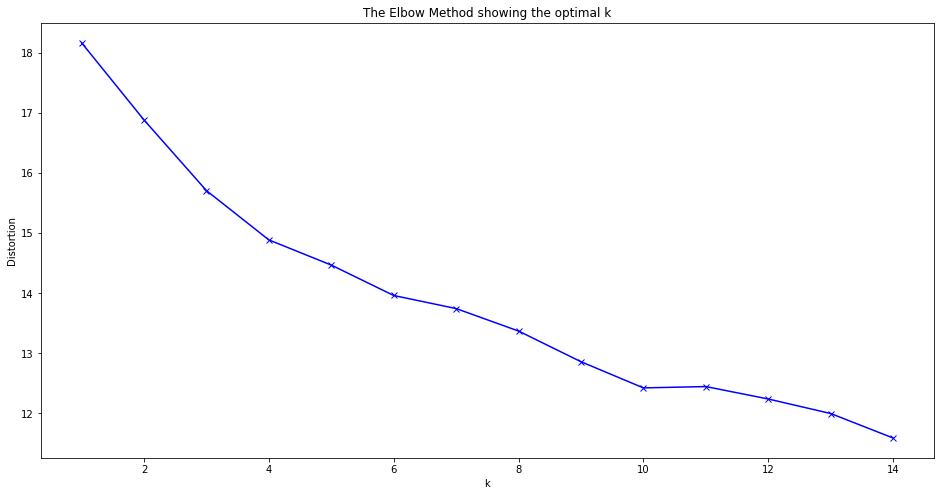

In [70]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

The Elbow is at k =10

In [71]:
# set number of clusters
kclusters =10

# set a variable
singapore_grouped_clustering = singapore2_grouped

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(singapore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 3, 3, 1, 3, 2, 7], dtype=int32)

In [72]:
# this code is added because without it, the following insert code always gives an error that the column already exists
if 'Cluster Labels' in school_venues_sorted.columns:
    school_venues_sorted.drop(labels='Cluster Labels', axis=1, inplace=True)

school_venues_sorted.head()

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ADMIRALTY SECONDARY SCHOOL,Food Court,Park,Paper / Office Supplies Store,Shopping Plaza,Yunnan Restaurant,Factory,Food & Drink Shop,Food,Flower Shop,Flea Market
1,AHMAD IBRAHIM SECONDARY SCHOOL,Coffee Shop,Food Court,Hot Spring,Indian Restaurant,Bus Stop,Asian Restaurant,Food & Drink Shop,Food,Farm,Food Truck
2,ANDERSON SECONDARY SCHOOL,Food Court,Asian Restaurant,Seafood Restaurant,Noodle House,Grocery Store,Restaurant,Coffee Shop,Convenience Store,College Cafeteria,Indian Restaurant
3,ANDERSON SERANGOON JUNIOR COLLEGE,Food Court,Convenience Store,College Cafeteria,Tennis Court,Fast Food Restaurant,Park,College Auditorium,Dessert Shop,Flower Shop,Factory
4,ANG MO KIO SECONDARY SCHOOL,Chinese Restaurant,Food Court,Asian Restaurant,General Entertainment,Fast Food Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Noodle House,Dog Run,Pizza Place


In [73]:
# adding the cluster labels

school_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_, True)

school_venues_sorted.head()

,Cluster Labels,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,ADMIRALTY SECONDARY SCHOOL,Food Court,Park,Paper / Office Supplies Store,Shopping Plaza,Yunnan Restaurant,Factory,Food & Drink Shop,Food,Flower Shop,Flea Market
1,2,AHMAD IBRAHIM SECONDARY SCHOOL,Coffee Shop,Food Court,Hot Spring,Indian Restaurant,Bus Stop,Asian Restaurant,Food & Drink Shop,Food,Farm,Food Truck
2,2,ANDERSON SECONDARY SCHOOL,Food Court,Asian Restaurant,Seafood Restaurant,Noodle House,Grocery Store,Restaurant,Coffee Shop,Convenience Store,College Cafeteria,Indian Restaurant
3,2,ANDERSON SERANGOON JUNIOR COLLEGE,Food Court,Convenience Store,College Cafeteria,Tennis Court,Fast Food Restaurant,Park,College Auditorium,Dessert Shop,Flower Shop,Factory
4,3,ANG MO KIO SECONDARY SCHOOL,Chinese Restaurant,Food Court,Asian Restaurant,General Entertainment,Fast Food Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Noodle House,Dog Run,Pizza Place


In [74]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
# I changed the "join" to "merge" because using the former changes the cluster labels dtype to float but I don't know why, 
# and I tried to change the datatype using astype, but it gave an eroor saying non finite digits can not be converted

singapore_merged = pd.merge(schcor_df, school_venues_sorted, on='School Name')

singapore_merged.head() # check the last columns!

,School Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ADMIRALTY SECONDARY SCHOOL,1.445960,103.802785,2,Food Court,Park,Paper / Office Supplies Store,Shopping Plaza,Yunnan Restaurant,Factory,Food & Drink Shop,Food,Flower Shop,Flea Market
1,AHMAD IBRAHIM SECONDARY SCHOOL,1.436070,103.830150,2,Coffee Shop,Food Court,Hot Spring,Indian Restaurant,Bus Stop,Asian Restaurant,Food & Drink Shop,Food,Farm,Food Truck
2,ANDERSON SECONDARY SCHOOL,1.375088,103.851594,2,Food Court,Asian Restaurant,Seafood Restaurant,Noodle House,Grocery Store,Restaurant,Coffee Shop,Convenience Store,College Cafeteria,Indian Restaurant
3,ANDERSON SERANGOON JUNIOR COLLEGE,1.378750,103.845911,2,Food Court,Convenience Store,College Cafeteria,Tennis Court,Fast Food Restaurant,Park,College Auditorium,Dessert Shop,Flower Shop,Factory
4,ANG MO KIO SECONDARY SCHOOL,1.367770,103.842520,3,Chinese Restaurant,Food Court,Asian Restaurant,General Entertainment,Fast Food Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Noodle House,Dog Run,Pizza Place


In [75]:
# check
singapore_merged.shape

(162, 14)

Finally, let's visualize the resulting clusters

In [76]:
address = 'Singapore, SG'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Singapore are {}. {}.'.format(latitude, longitude))

The geographical coordinate of Singapore are 1.357107. 103.8194992.


In [77]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


In [78]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(singapore_merged['Latitude'], singapore_merged['Longitude'], singapore_merged['School Name'], singapore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

2). Examine Clusters Now, you can examine each cluster

In [80]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 0, singapore_merged.columns[[0] + list(range(4, singapore_merged.shape[1]))]]

#This is the loner Cluster

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,BOON LAY SECONDARY SCHOOL,Playground,Asian Restaurant,Yunnan Restaurant,Factory,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop


In [82]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 1, singapore_merged.columns[[0] + list(range(4, singapore_merged.shape[1]))]]

#This is the food and gym Cluster

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,ANGLO-CHINESE JUNIOR COLLEGE,Coffee Shop,Japanese Restaurant,Dessert Shop,Korean Restaurant,Sandwich Place,Bar,Food Court,Malay Restaurant,Supermarket,Steakhouse
14,BEDOK SOUTH SECONDARY SCHOOL,Park,Flower Shop,Trail,Bus Line,Arts & Entertainment,Bus Station,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market
22,BUKIT PANJANG GOVT. HIGH SCHOOL,Bus Station,Bowling Alley,Pet Store,Gym,Food,Café,Supermarket,Lounge,Chinese Restaurant,Beer Garden
28,CHANGKAT CHANGI SECONDARY SCHOOL,Coffee Shop,Sandwich Place,Japanese Restaurant,Pharmacy,Bakery,Shopping Mall,Food Court,Soup Place,Fried Chicken Joint,Shabu-Shabu Restaurant
29,CHIJ KATONG CONVENT,Noodle House,Convenience Store,Park,Beach,Pet Store,Snack Place,Outdoors & Recreation,Coffee Shop,Grocery Store,Bike Rental / Bike Share
30,CHIJ SECONDARY (TOA PAYOH),Bus Stop,Dessert Shop,Convenience Store,Food Court,Office,Bookstore,Bus Station,Gym,Kids Store,Flea Market
32,CHIJ ST. NICHOLAS GIRLS' SCHOOL,Fast Food Restaurant,Soup Place,Buffet,Pharmacy,Food Court,Indian Restaurant,Chinese Restaurant,Farm,Food Truck,Food & Drink Shop
38,CLEMENTI TOWN SECONDARY SCHOOL,Food Court,Dessert Shop,Coffee Shop,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Noodle House,Electronics Store,Chinese Breakfast Place,Bus Station
39,COMMONWEALTH SECONDARY SCHOOL,Athletics & Sports,Park,Malay Restaurant,Indian Restaurant,Recreation Center,Steakhouse,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop
41,CRESCENT GIRLS' SCHOOL,Gym,Park,Train Station,Asian Restaurant,Food & Drink Shop,Food,Flower Shop,Flea Market,Exhibit,Food Court


In [84]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 2, singapore_merged.columns[[0] + list(range(4, singapore_merged.shape[1]))]]

#This is the food court Cluster

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ADMIRALTY SECONDARY SCHOOL,Food Court,Park,Paper / Office Supplies Store,Shopping Plaza,Yunnan Restaurant,Factory,Food & Drink Shop,Food,Flower Shop,Flea Market
1,AHMAD IBRAHIM SECONDARY SCHOOL,Coffee Shop,Food Court,Hot Spring,Indian Restaurant,Bus Stop,Asian Restaurant,Food & Drink Shop,Food,Farm,Food Truck
2,ANDERSON SECONDARY SCHOOL,Food Court,Asian Restaurant,Seafood Restaurant,Noodle House,Grocery Store,Restaurant,Coffee Shop,Convenience Store,College Cafeteria,Indian Restaurant
3,ANDERSON SERANGOON JUNIOR COLLEGE,Food Court,Convenience Store,College Cafeteria,Tennis Court,Fast Food Restaurant,Park,College Auditorium,Dessert Shop,Flower Shop,Factory
8,ANGLO-CHINESE SCHOOL (INDEPENDENT),Bakery,Grocery Store,Food Court,Comfort Food Restaurant,Dessert Shop,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market
10,ASSUMPTION PATHWAY SCHOOL,Pool,Food Court,Bus Station,Seafood Restaurant,French Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market
15,BEDOK VIEW SECONDARY SCHOOL,Food Court,Coffee Shop,Noodle House,Bus Station,Lake,Gas Station,Playground,Convenience Store,Bus Line,Asian Restaurant
23,BUKIT VIEW SECONDARY SCHOOL,Food Court,Coffee Shop,Grocery Store,Pool,Food,Fast Food Restaurant,Skate Park,Bus Station,Park,Bakery
24,CANBERRA SECONDARY SCHOOL,Food Court,Convenience Store,Food & Drink Shop,Coffee Shop,Basketball Court,Yunnan Restaurant,Farm,French Restaurant,Food Truck,Food
25,CATHOLIC HIGH SCHOOL,Cosmetics Shop,Food Court,Noodle House,Park,Soup Place,Bakery,BBQ Joint,Grocery Store,Bubble Tea Shop,Drugstore


In [86]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 3, singapore_merged.columns[[0] + list(range(4, singapore_merged.shape[1]))]]

#This is the restaurant Cluster

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,ANG MO KIO SECONDARY SCHOOL,Chinese Restaurant,Food Court,Asian Restaurant,General Entertainment,Fast Food Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Noodle House,Dog Run,Pizza Place
5,ANGLICAN HIGH SCHOOL,Coffee Shop,Noodle House,Chinese Restaurant,Asian Restaurant,Seafood Restaurant,Gas Station,Café,Food Court,Indian Restaurant,Ice Cream Shop
7,ANGLO-CHINESE SCHOOL (BARKER ROAD),Chinese Restaurant,Music School,Seafood Restaurant,Grocery Store,Nightclub,Pizza Place,American Restaurant,Food,Flower Shop,Flea Market
12,BEATTY SECONDARY SCHOOL,Chinese Restaurant,Noodle House,Seafood Restaurant,Steakhouse,Asian Restaurant,Japanese Restaurant,Supermarket,Thai Restaurant,Food Court,Trail
13,BEDOK GREEN SECONDARY SCHOOL,Chinese Restaurant,Bus Stop,Thai Restaurant,Noodle House,Dessert Shop,Gym Pool,Food Court,Cafeteria,Seafood Restaurant,Café
16,BENDEMEER SECONDARY SCHOOL,Chinese Restaurant,Coffee Shop,Seafood Restaurant,Cafeteria,Soccer Stadium,Bakery,Supermarket,Pool,Dim Sum Restaurant,Dessert Shop
19,BROADRICK SECONDARY SCHOOL,Noodle House,Chinese Restaurant,Dessert Shop,Asian Restaurant,Food Court,Snack Place,Seafood Restaurant,BBQ Joint,Performing Arts Venue,Coffee Shop
20,BUKIT BATOK SECONDARY SCHOOL,Chinese Restaurant,Bus Line,Food Court,Gas Station,Park,Coffee Shop,Seafood Restaurant,Café,Bus Stop,Skate Park
21,BUKIT MERAH SECONDARY SCHOOL,Coffee Shop,Chinese Restaurant,Café,Vegetarian / Vegan Restaurant,Malay Restaurant,Bistro,Italian Restaurant,Ice Cream Shop,Performing Arts Venue,Food Court
33,CHIJ ST. THERESA'S CONVENT,Chinese Restaurant,Food Court,Bus Stop,Bus Station,Vegetarian / Vegan Restaurant,Soccer Field,Coffee Shop,Café,Basketball Court,Asian Restaurant


In [87]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 4, singapore_merged.columns[[0] + list(range(4, singapore_merged.shape[1]))]]

#This is another loner with Multiplex Cluster

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
160,ZHENGHUA SECONDARY SCHOOL,Multiplex,Bus Station,Fast Food Restaurant,Yunnan Restaurant,Farm,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop


In [88]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 5, singapore_merged.columns[[0] + list(range(4, singapore_merged.shape[1]))]]

#This is another loner with Plaza Cluster

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,CATHOLIC JUNIOR COLLEGE,Plaza,Hostel,Bus Station,College Administrative Building,Factory,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop


In [90]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 6, singapore_merged.columns[[0] + list(range(4, singapore_merged.shape[1]))]]

#This is coffee shop Cluster

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,BOWEN SECONDARY SCHOOL,Coffee Shop,Convenience Store,Food Court,Pet Store,Asian Restaurant,Bus Stop,Shop & Service,Farm,Food & Drink Shop,Food
37,CHUNG CHENG HIGH SCHOOL (YISHUN),Coffee Shop,Asian Restaurant,Food Court,Train Station,American Restaurant,Fast Food Restaurant,Bus Line,Shopping Mall,Rest Area,Café
40,COMPASSVALE SECONDARY SCHOOL,Playground,Coffee Shop,Sculpture Garden,Yunnan Restaurant,Exhibit,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
66,JUNYUAN SECONDARY SCHOOL,Coffee Shop,Fast Food Restaurant,Food Court,Supermarket,Food & Drink Shop,Music Store,Grocery Store,Park,Bus Station,Thai Restaurant
73,KUO CHUAN PRESBYTERIAN SECONDARY SCHOOL,Coffee Shop,Food Court,Gym,Seafood Restaurant,Yunnan Restaurant,Factory,Food Truck,Food & Drink Shop,Food,Flower Shop
74,LOYANG VIEW SECONDARY SCHOOL,Coffee Shop,Noodle House,Supermarket,Bus Station,General Entertainment,Yunnan Restaurant,Food Court,Food & Drink Shop,Food,Flower Shop
81,MILLENNIA INSTITUTE,Coffee Shop,Pizza Place,Bus Line,Bus Stop,Supermarket,Gas Station,Café,Chinese Restaurant,Food Court,Park
93,NORTHLAND SECONDARY SCHOOL,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Thai Restaurant,Café,Cafeteria,College Bookstore,Vegetarian / Vegan Restaurant,Indian Restaurant,Ice Cream Shop
96,ORCHID PARK SECONDARY SCHOOL,Coffee Shop,Grocery Store,Shopping Mall,Fast Food Restaurant,Supermarket,Asian Restaurant,Bus Line,Food Court,American Restaurant,Food
98,PASIR RIS CREST SECONDARY SCHOOL,Coffee Shop,Convenience Store,Food,Supermarket,Bus Line,Bus Station,Electronics Store,Noodle House,Drugstore,Dumpling Restaurant


In [92]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 7, singapore_merged.columns[[0] + list(range(4, singapore_merged.shape[1]))]]

#This is bus station Cluster

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,ASSUMPTION ENGLISH SCHOOL,Pool,Garden,Bus Station,Casino,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
11,BARTLEY SECONDARY SCHOOL,Chinese Aristocrat Restaurant,Metro Station,Bus Station,Chinese Restaurant,Yunnan Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
27,CEDAR GIRLS' SECONDARY SCHOOL,Bus Station,Noodle House,Food Court,Martial Arts Dojo,Café,Coffee Shop,Chinese Restaurant,Yunnan Restaurant,Food & Drink Shop,Food
65,HWA CHONG INSTITUTION,Pool,Food,Bus Station,Train Station,Factory,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
76,MARIS STELLA HIGH SCHOOL,Bus Station,Metro Station,Park,Yunnan Restaurant,Farm,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
85,NANYANG GIRLS' HIGH SCHOOL,Bakery,Seafood Restaurant,Bus Station,Pool,Department Store,Deli / Bodega,Food Truck,Food Court,Food & Drink Shop,Food
86,NANYANG JUNIOR COLLEGE,Bus Station,Trail,Pizza Place,Deli / Bodega,Dessert Shop,Indian Restaurant,Indonesian Restaurant,Tennis Court,Yunnan Restaurant,Farmers Market
103,PEIRCE SECONDARY SCHOOL,Bus Station,Coffee Shop,Bubble Tea Shop,Tennis Court,Gym,Park,Fast Food Restaurant,Field,Fish & Chips Shop,Yunnan Restaurant
133,TAMPINES MERIDIAN JUNIOR COLLEGE,Bus Station,Park,Grocery Store,Chinese Restaurant,Coffee Shop,Spa,Flea Market,Flower Shop,Factory,Fish & Chips Shop
140,TEMASEK SECONDARY SCHOOL,Bus Station,Grocery Store,Convenience Store,Dance Studio,Indian Restaurant,Flea Market,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop


In [94]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 8, singapore_merged.columns[[0] + list(range(4, singapore_merged.shape[1]))]]

#This is Grocery Store Cluster

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,CHIJ ST. JOSEPH'S CONVENT,Fast Food Restaurant,Sandwich Place,Coffee Shop,Food Court,Snack Place,Bus Station,Japanese Restaurant,Farm,Farmers Market,Field
35,CHUA CHU KANG SECONDARY SCHOOL,Grocery Store,Convenience Store,Bus Stop,Coffee Shop,Fast Food Restaurant,Gym,Factory,Food Court,Food & Drink Shop,Food
67,JURONG PIONEER JUNIOR COLLEGE,Convenience Store,Bus Stop,Coffee Shop,Fast Food Restaurant,Yunnan Restaurant,Farm,Food Truck,Food Court,Food & Drink Shop,Food
68,JURONG SECONDARY SCHOOL,Fast Food Restaurant,Grocery Store,Food Court,Coffee Shop,Yunnan Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market
123,SPRINGFIELD SECONDARY SCHOOL,Fast Food Restaurant,Coffee Shop,Food Court,Grocery Store,Café,College Cafeteria,Thai Restaurant,Supermarket,Yunnan Restaurant,Field
124,ST. ANDREW'S JUNIOR COLLEGE,Coffee Shop,Convenience Store,Fast Food Restaurant,Food Court,Seafood Restaurant,Trail,Market,Bus Station,Snack Place,Farm
128,ST. HILDA'S SECONDARY SCHOOL,Coffee Shop,Fast Food Restaurant,Food Court,Halal Restaurant,Vegetarian / Vegan Restaurant,Playground,Malay Restaurant,Restaurant,Bakery,Grocery Store
138,TECK WHYE SECONDARY SCHOOL,Grocery Store,Coffee Shop,Bus Station,Bus Stop,Fast Food Restaurant,Thai Restaurant,Convenience Store,Donut Shop,Drugstore,Food Truck


In [95]:
singapore_merged.loc[singapore_merged['Cluster Labels'] == 9, singapore_merged.columns[[0] + list(range(4, singapore_merged.shape[1]))]]

#This is loner car related Cluster

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
158,YUSOF ISHAK SECONDARY SCHOOL,Rental Car Location,Gas Station,Yunnan Restaurant,Factory,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
